# CNN

## Imports

Nothing to see here.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, losses, models

from src.util import (
    load_star_galaxy_dataset,
    star_galaxy_split,
    train_val_test_split,
    STAR,
    GALAXY,
)

%matplotlib inline

2023-04-15 23:22:02.747674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset

### Load Dataset

Here we load the whole dataset and store the target values as constants.

In [2]:
# Load dataset
dataset = load_star_galaxy_dataset()
print(f"{dataset.DESCR}\n")
print(f"Dataset size: {len(dataset.image)} images")

This is a simple dataset consisting of ~3000 64x64 images of stars and ~1000 images of galaxies. The images were captured by the in-house 1.3m telescope of the observatory situated in Devasthal, Nainital, India.

Dataset size: 3986 images


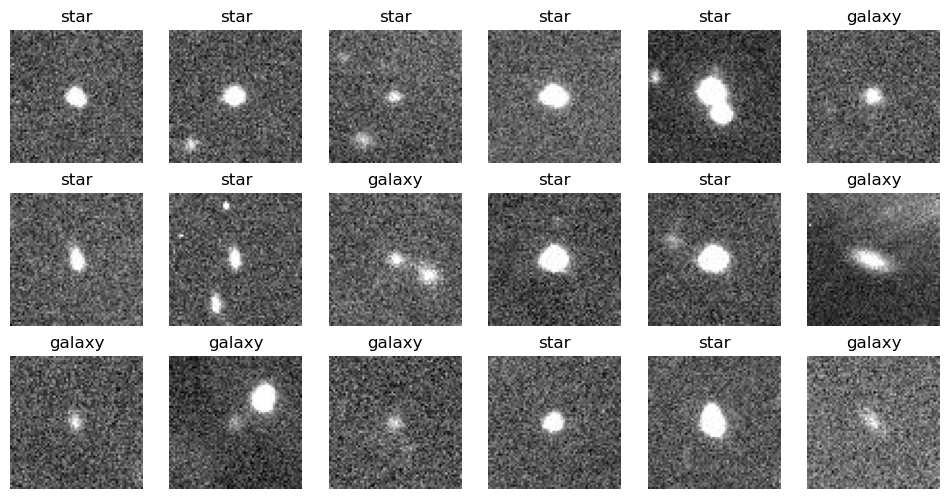

In [3]:
w, h = 6, 3

_, axs_list = plt.subplots(h, w, figsize=(2 * w, 2 * h))

_i = 0  # Index traversing the random indices
indices = np.random.choice(len(dataset.image), size=(w * h))
for axs in axs_list:
    for ax in axs:
        i = indices[_i]
        ax.axis("off")
        ax.imshow(dataset.image[i], cmap="gray")
        ax.set_title(dataset.target_names[dataset.target[i]])
        _i += 1

Now we can split the dataset into train and test sets.

In [4]:
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
    dataset.image, dataset.target
)
print(f"x_train: {x_train.shape[0]} images")
print(f"x_val: {x_val.shape[0]} images")
print(f"x_test: {x_test.shape[0]} images")

x_train: 3188 images
x_val: 399 images
x_test: 399 images


## Building the Layers

Much like an onion or an ogre, a CNN model consists of layers.

The first few layers work with the input images more intuitively. The model takes in grayscale images, rescaling the `[0, 255]` values to `[0, 1]` (in both training and inference).

It also (in training) randomly flips and rotates images. This is helpful to the model since we have a relatively small dataset.

In [5]:
model = models.Sequential()
model.add(layers.Input(shape=(64, 64, 1)))  # 64x64 grayscale images
model.add(layers.Rescaling(scale=(1.0 / 255)))  # Rescale values to [0, 1]
model.add(layers.RandomFlip())
model.add(layers.RandomRotation(factor=0.2))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 1)         0         
                                                                 
 random_flip (RandomFlip)    (None, 64, 64, 1)         0         
                                                                 
 random_rotation (RandomRota  (None, 64, 64, 1)        0         
 tion)                                                           
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


2023-04-15 23:22:04.997986: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


The model goes through convolutions.

In [6]:
# First convolution
model.add(layers.Conv2D(filters=32, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=2))

# Second convolution
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=2))

# Third convolution
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=2))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 1)         0         
                                                                 
 random_flip (RandomFlip)    (None, 64, 64, 1)         0         
                                                                 
 random_rotation (RandomRota  (None, 64, 64, 1)        0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        1

Finally, the model flattens the processed data and feeds it into a Deep Neural Network.

In [7]:
model.add(layers.Flatten())
model.add(layers.Dense(units=64, activation="relu"))
model.add(layers.Dense(units=2))  # Output layer
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 1)         0         
                                                                 
 random_flip (RandomFlip)    (None, 64, 64, 1)         0         
                                                                 
 random_rotation (RandomRota  (None, 64, 64, 1)        0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        1

## Training the Model

In [8]:
model.compile(
    optimizer="adam",
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [9]:
history = model.fit(
    x_train,
    y_train,
    epochs=15,
    validation_data=(x_val, y_val),
)

Epoch 1/15
100/100 [==============================] - 12s 119ms/step - loss: 0.5264 - accuracy: 0.7613 - val_loss: 0.3985 - val_accuracy: 0.7845
Epoch 2/15
100/100 [==============================] - 12s 119ms/step - loss: 0.4036 - accuracy: 0.7980 - val_loss: 0.5641 - val_accuracy: 0.6842
Epoch 3/15
100/100 [==============================] - 12s 120ms/step - loss: 0.3595 - accuracy: 0.8403 - val_loss: 0.4439 - val_accuracy: 0.8020
Epoch 4/15
100/100 [==============================] - 10s 100ms/step - loss: 0.3299 - accuracy: 0.8617 - val_loss: 0.3308 - val_accuracy: 0.8697
Epoch 5/15
100/100 [==============================] - 11s 112ms/step - loss: 0.3122 - accuracy: 0.8730 - val_loss: 0.3608 - val_accuracy: 0.8596
Epoch 6/15
100/100 [==============================] - 12s 115ms/step - loss: 0.3015 - accuracy: 0.8758 - val_loss: 0.2950 - val_accuracy: 0.8722
Epoch 7/15
100/100 [==============================] - 11s 108ms/step - loss: 0.2879 - accuracy: 0.8786 - val_loss: 0.2961 - val_ac

## Evaluating the Model

In [10]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
val_loss, val_acc = model.evaluate(x_val, y_val, verbose=2)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

100/100 - 2s - loss: 0.2501 - accuracy: 0.8930 - 2s/epoch - 22ms/step
13/13 - 0s - loss: 0.2651 - accuracy: 0.8872 - 104ms/epoch - 8ms/step
13/13 - 0s - loss: 0.2301 - accuracy: 0.9173 - 346ms/epoch - 27ms/step


Let's see how the model performed with each epoch.

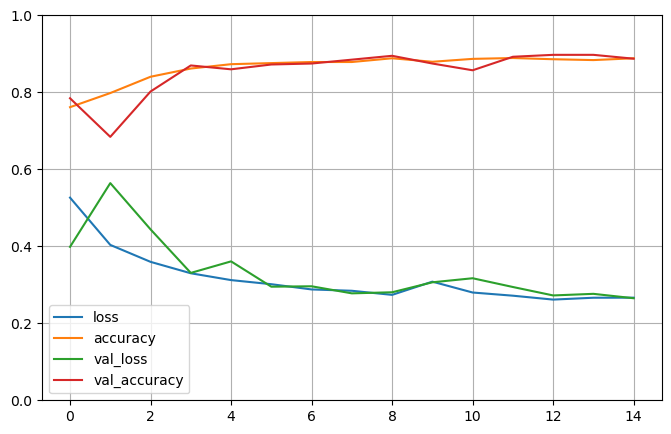

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Now, let's see how accurate it is with each dataset and (more importantly) with stars XOR galaxies. We first need to extract the subset of just the stars and also the subset of just the galaxies.

In [12]:
for _x, _y, _name in zip(
    [dataset.image, x_train, x_val, x_test],
    [dataset.target, y_train, y_val, y_test],
    ["FULL", "TRAIN", "VAL", "TEST"],
):
    print(_name)
    print("-" * len(_name))
    print("overall", end="\t\t")
    loss, acc = model.evaluate(_x, _y, verbose=2)

    stars, galaxies = star_galaxy_split(_x, _y)
    print("stars", end="\t\t")
    star_loss, star_acc = model.evaluate(stars, np.full(len(stars), STAR), verbose=2)
    print("galaxies", end="\t")
    galaxy_loss, galaxy_acc = model.evaluate(
        galaxies, np.full(len(galaxies), GALAXY), verbose=2
    )
    print()

FULL
----
overall		125/125 - 1s - loss: 0.2496 - accuracy: 0.8949 - 1s/epoch - 12ms/step
stars		96/96 - 2s - loss: 0.1218 - accuracy: 0.9570 - 2s/epoch - 22ms/step
galaxies	30/30 - 1s - loss: 0.6626 - accuracy: 0.6943 - 917ms/epoch - 31ms/step

TRAIN
-----
overall		100/100 - 3s - loss: 0.2501 - accuracy: 0.8930 - 3s/epoch - 30ms/step
stars		76/76 - 2s - loss: 0.1216 - accuracy: 0.9572 - 2s/epoch - 32ms/step
galaxies	24/24 - 1s - loss: 0.6635 - accuracy: 0.6865 - 840ms/epoch - 35ms/step

VAL
---
overall		13/13 - 0s - loss: 0.2651 - accuracy: 0.8872 - 464ms/epoch - 36ms/step
stars		10/10 - 0s - loss: 0.1375 - accuracy: 0.9457 - 442ms/epoch - 44ms/step
galaxies	3/3 - 0s - loss: 0.7294 - accuracy: 0.6744 - 164ms/epoch - 55ms/step

TEST
----
overall		13/13 - 0s - loss: 0.2301 - accuracy: 0.9173 - 470ms/epoch - 36ms/step
stars		10/10 - 0s - loss: 0.1070 - accuracy: 0.9666 - 395ms/epoch - 39ms/step
galaxies	4/4 - 0s - loss: 0.5983 - accuracy: 0.7700 - 133ms/epoch - 33ms/step



## Problem

The dataset we use has far more images of stars than galaxies, almost 3 times as many. This presents a challenge when it comes to classification, as the model could easily guess "star" for any given image and have essentially a 1/4 chance of being right.

In [13]:
all_stars, all_galaxies = star_galaxy_split(dataset.image, dataset.target)
print(f"stars: {len(all_stars)} images")
print(f"galaxies: {len(all_galaxies)} images")

stars: 3044 images
galaxies: 942 images


## Attempt at a Solution

Our attempt at| solving this problem is to only use a subset of the entire dataset. We use a sample of about 1,000 random images of the stars, to have an even number of both classes in training and testing.

In [14]:
dataset_even = load_star_galaxy_dataset(even=True)
print(f"'Even' dataset size: {len(dataset_even.image)} images")

'Even' dataset size: 1884 images


In [15]:
x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
    dataset_even.image, dataset_even.target
)
print(f"x_train: {x_train.shape[0]} images")
print(f"x_val: {x_val.shape[0]} images")
print(f"x_test: {x_test.shape[0]} images")

x_train: 1507 images
x_val: 188 images
x_test: 189 images


In [16]:
history_even = model.fit(
    x_train,
    y_train,
    epochs=15,
    validation_data=(x_val, y_val),
)

Epoch 1/15
48/48 [==============================] - 5s 106ms/step - loss: 0.3557 - accuracy: 0.8514 - val_loss: 0.2916 - val_accuracy: 0.8883
Epoch 2/15
48/48 [==============================] - 5s 113ms/step - loss: 0.3369 - accuracy: 0.8607 - val_loss: 0.3733 - val_accuracy: 0.8298
Epoch 3/15
48/48 [==============================] - 5s 106ms/step - loss: 0.3571 - accuracy: 0.8480 - val_loss: 0.3164 - val_accuracy: 0.8723
Epoch 4/15
48/48 [==============================] - 5s 103ms/step - loss: 0.3404 - accuracy: 0.8520 - val_loss: 0.3061 - val_accuracy: 0.8989
Epoch 5/15
48/48 [==============================] - 5s 112ms/step - loss: 0.3151 - accuracy: 0.8733 - val_loss: 0.3605 - val_accuracy: 0.8404
Epoch 6/15
48/48 [==============================] - 5s 110ms/step - loss: 0.3625 - accuracy: 0.8374 - val_loss: 0.2863 - val_accuracy: 0.8936
Epoch 7/15
48/48 [==============================] - 6s 115ms/step - loss: 0.3112 - accuracy: 0.8806 - val_loss: 0.2812 - val_accuracy: 0.8883
Epoch 

In [17]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
val_loss, val_acc = model.evaluate(x_val, y_val, verbose=2)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)

48/48 - 1s - loss: 0.3259 - accuracy: 0.8646 - 1s/epoch - 28ms/step
6/6 - 0s - loss: 0.3130 - accuracy: 0.8670 - 162ms/epoch - 27ms/step
6/6 - 0s - loss: 0.2452 - accuracy: 0.8942 - 129ms/epoch - 21ms/step


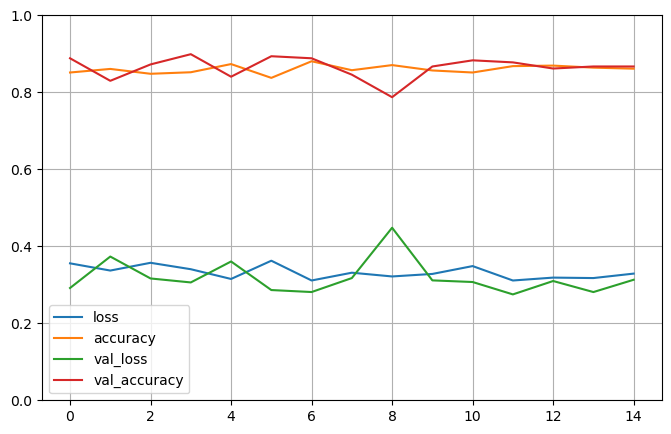

In [18]:
pd.DataFrame(history_even.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [19]:
for _x, _y, _name in zip(
    [dataset.image, dataset_even.image, x_train, x_val, x_test],
    [dataset.target, dataset_even.target, y_train, y_val, y_test],
    ["FULL", "EVEN", "TRAIN", "VAL", "TEST"],
):
    print(_name)
    print("-" * len(_name))
    print("overall", end="\t\t")
    loss, acc = model.evaluate(_x, _y, verbose=2)

    stars, galaxies = star_galaxy_split(_x, _y)
    print("stars", end="\t\t")
    star_loss, star_acc = model.evaluate(stars, np.full(len(stars), STAR), verbose=2)
    print("galaxies", end="\t")
    galaxy_loss, galaxy_acc = model.evaluate(
        galaxies, np.full(len(galaxies), GALAXY), verbose=2
    )
    print()

FULL
----
overall		125/125 - 3s - loss: 0.3769 - accuracy: 0.8334 - 3s/epoch - 27ms/step
stars		96/96 - 2s - loss: 0.4350 - accuracy: 0.8003 - 2s/epoch - 23ms/step
galaxies	30/30 - 1s - loss: 0.1893 - accuracy: 0.9406 - 813ms/epoch - 27ms/step

EVEN
----
overall		59/59 - 1s - loss: 0.3165 - accuracy: 0.8678 - 702ms/epoch - 12ms/step
stars		30/30 - 1s - loss: 0.4438 - accuracy: 0.7951 - 1s/epoch - 38ms/step
galaxies	30/30 - 1s - loss: 0.1893 - accuracy: 0.9406 - 836ms/epoch - 28ms/step

TRAIN
-----
overall		48/48 - 1s - loss: 0.3259 - accuracy: 0.8646 - 1s/epoch - 30ms/step
stars		24/24 - 1s - loss: 0.4596 - accuracy: 0.7870 - 822ms/epoch - 34ms/step
galaxies	24/24 - 1s - loss: 0.1931 - accuracy: 0.9418 - 829ms/epoch - 35ms/step

VAL
---
overall		6/6 - 0s - loss: 0.3130 - accuracy: 0.8670 - 181ms/epoch - 30ms/step
stars		3/3 - 0s - loss: 0.4480 - accuracy: 0.7826 - 81ms/epoch - 27ms/step
galaxies	3/3 - 0s - loss: 0.1837 - accuracy: 0.9479 - 121ms/epoch - 40ms/step

TEST
----
overall		6/

## Conclusions

TBD